In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('/content/ALL_FAIL_LOG_RATE.csv')

In [5]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (4900, 15)

Columns:
 Index(['LineNO', 'TimeUS', 'RDes', 'R', 'Rout', 'PDes', 'P', 'POut', 'YDes',
       'Y', 'YOut', 'ADes', 'A', 'AOut', 'labels'],
      dtype='object')

Sample Data:
    LineNO    TimeUS      RDes         R      Rout      PDes         P  \
0    1715  15363852 -0.080699  0.008877 -0.000223 -0.032351  0.005687   
1    1797  15463812 -0.080392  0.009570 -0.000201 -0.033152  0.008595   
2    1876  15563772 -0.080012  0.009819 -0.000219 -0.034111  0.007455   
3    1955  15663732 -0.080031  0.008554 -0.000202 -0.034064  0.004384   
4    2034  15763692 -0.079839  0.011863 -0.000230 -0.034537  0.010646   

       POut      YDes         Y      YOut      ADes         A  AOut  labels  
0 -0.000096  0.000005  1.377302 -0.002177  0.476742  0.476742   0.0       0  
1 -0.000117  0.000007  1.358535 -0.002151  0.450039  0.450039   0.0       0  
2 -0.000108  0.000009  1.342084 -0.002124  0.458717  0.458717   0.0       0  
3 -0.000102  0.000008  1.323240 -0.002100  0.5

In [6]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNO      int64
TimeUS      int64
RDes      float64
R         float64
Rout      float64
PDes      float64
P         float64
POut      float64
YDes      float64
Y         float64
YOut      float64
ADes      float64
A         float64
AOut      float64
labels      int64
dtype: object



Label Distribution:
 labels
0    2460
4     754
1     610
2     593
3     483
Name: count, dtype: int64


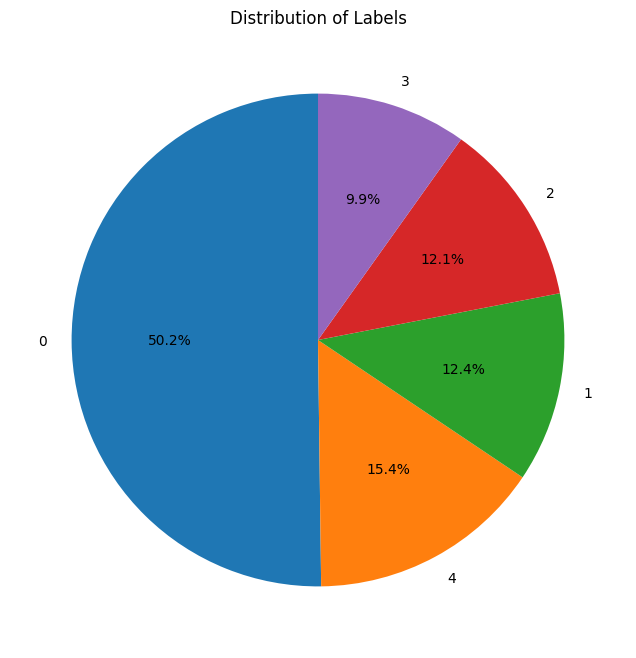

In [7]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_counts)
    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Labels')
    plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0    500
4    154
1    113
2    110
3    103
Name: count, dtype: int64


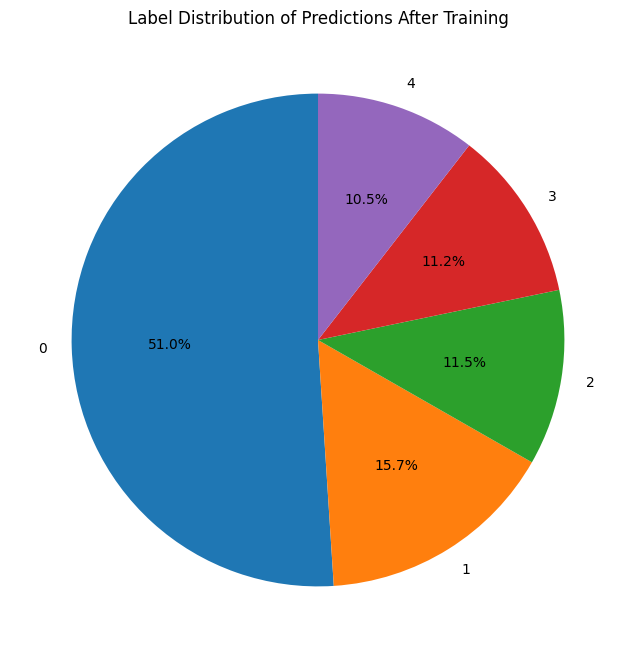

In [26]:
# Get the label distribution after training
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(8, 8))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution of Predictions After Training')
plt.show()

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [11]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [12]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [14]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [15]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [16]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [17]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [18]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [19]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=1, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1


Training fold 1...
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.6999 - loss: 0.8013 - val_accuracy: 0.7214 - val_loss: 0.8257
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8559 - loss: 0.3706 - val_accuracy: 0.8949 - val_loss: 0.3746
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8838 - loss: 0.2903 - val_accuracy: 0.9276 - val_loss: 0.2356
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8727 - loss: 0.2937 - val_accuracy: 0.9194 - val_loss: 0.2046
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9103 - loss: 0.2259 - val_accuracy: 0.9204 - val_loss: 0.1921
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9207 - loss: 0.2189 - val_accuracy: 0.9347 - val_loss: 0.1764
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9100 - loss: 0.2227 - val_accuracy: 0.9520 - val_loss: 0.1348
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9176 - loss: 0.

In [20]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.9773


In [21]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9771
Label 1 Accuracy: 0.9455
Label 2 Accuracy: 0.9799
Label 3 Accuracy: 0.9904
Label 4 Accuracy: 0.9920


In [22]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9740    0.9838    0.9789       495
           1     1.0000    0.9262    0.9617       122
           2     0.9727    0.9907    0.9817       108
           3     1.0000    1.0000    1.0000       103
           4     0.9675    0.9803    0.9739       152

    accuracy                         0.9786       980
   macro avg     0.9829    0.9762    0.9792       980
weighted avg     0.9788    0.9786    0.9785       980



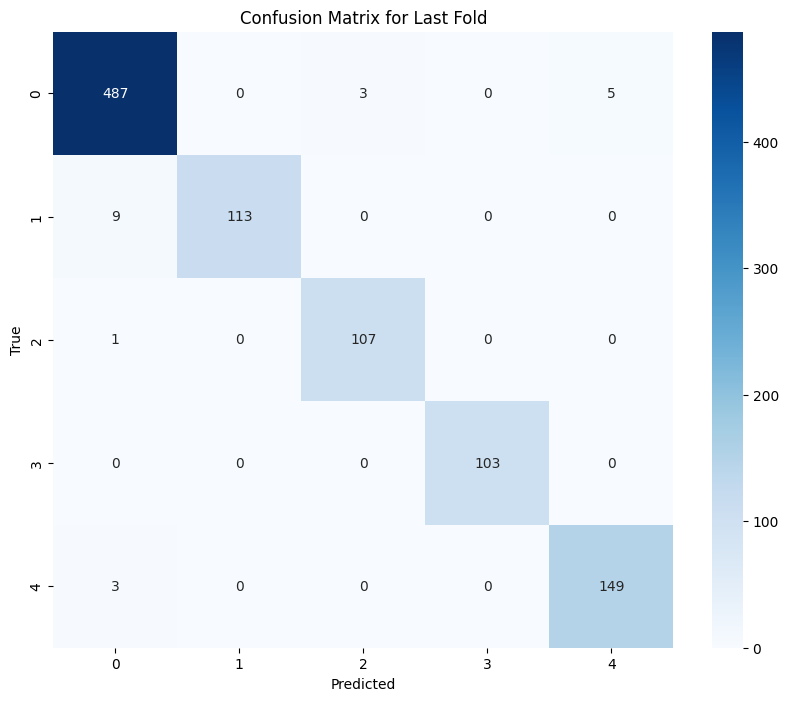

In [24]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Distribution of predicted labels (entire dataset):
0    2500
4     770
1     565
2     550
3     515
Name: count, dtype: int64


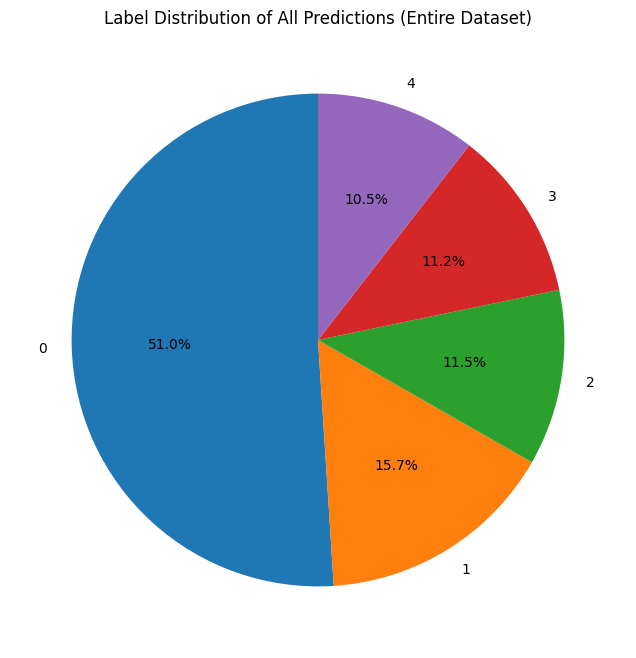

In [25]:
# Create lists to collect predictions
all_y_pred = []
all_y_true = []

for train_index, val_index in kf.split(X_reshaped):
    # ... (training code for each fold remains the same)

    # Predictions from this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Append predictions and true labels for this fold
    all_y_pred.extend(y_pred_classes)
    all_y_true.extend(y_true_classes)

# After all folds are complete, you can now examine the distribution
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Distribution of predictions across all data
print("\nDistribution of predicted labels (entire dataset):")
print(pd.Series(all_y_pred).value_counts())

# Plotting the pie chart for all predictions
plt.figure(figsize=(8, 8))
plt.pie(pd.Series(all_y_pred).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution of All Predictions (Entire Dataset)')
plt.show()

